In [1]:
#CNN-BiLSTM based GAN
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from keras.models import Model, Sequential
from keras.layers import Dense

2024-05-30 19:09:00.327314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the data
data = pd.read_csv('data/TVC_logger_1_sedge.csv')
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%d/%m/%Y %H:%M')
data.set_index('DateTime', inplace=True)

In [3]:
# Display the first few rows of the dataset
data.head()

,temp,humidity,vwc
DateTime,,,
2013-08-02 23:40:00,14.7258,86.00,0.3351
2013-08-02 23:50:00,13.8626,87.04,0.3351
2013-08-03 00:00:00,14.7916,88.40,0.3351
2013-08-03 00:10:00,15.1366,87.26,0.3351
2013-08-03 00:20:00,13.4238,87.70,0.3351


## Z-score

In [4]:

# Statistical Method: Z-score for multiple parameters
data[['temp_zscore', 'humidity_zscore', 'vwc_zscore']] = data[['temp', 'humidity', 'vwc']].apply(zscore)

# Define threshold for anomalies
threshold = 3
data['anomaly_zscore'] = (np.abs(data['temp_zscore']) > threshold) | (np.abs(data['humidity_zscore']) > threshold) | (np.abs(data['vwc_zscore']) > threshold)


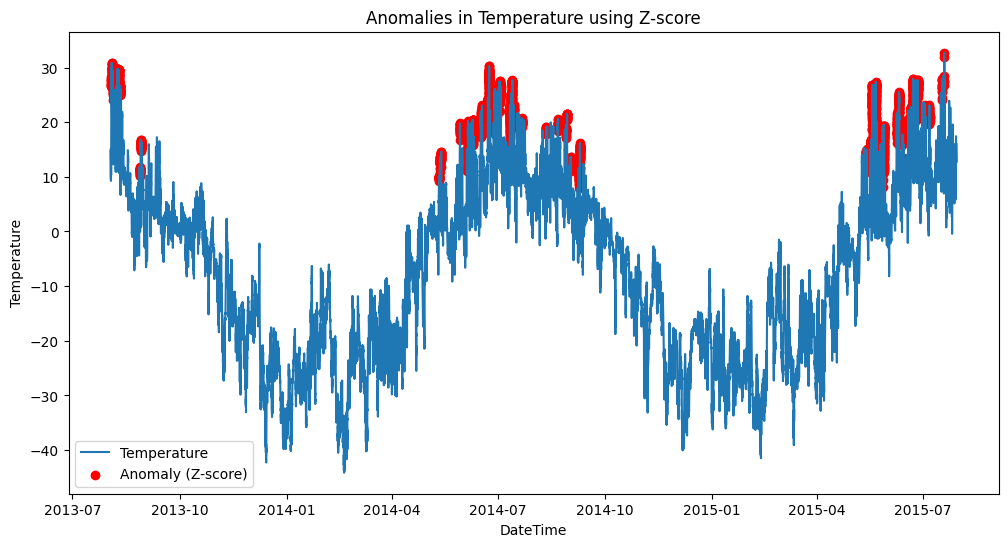

In [5]:
# Plot anomalies detected using Z-score
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temp'], label='Temperature')
plt.scatter(data.index[data['anomaly_zscore']], data['temp'][data['anomaly_zscore']], color='red', label='Anomaly (Z-score)')
plt.title('Anomalies in Temperature using Z-score')
plt.xlabel('DateTime')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Isolation Forest

In [6]:
# Machine Learning Method: Isolation Forest with multiple parameters
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['temp', 'humidity', 'vwc']])

# Fit Isolation Forest model
model_if = IsolationForest(contamination=0.01)
data['anomaly_if'] = model_if.fit_predict(scaled_features)

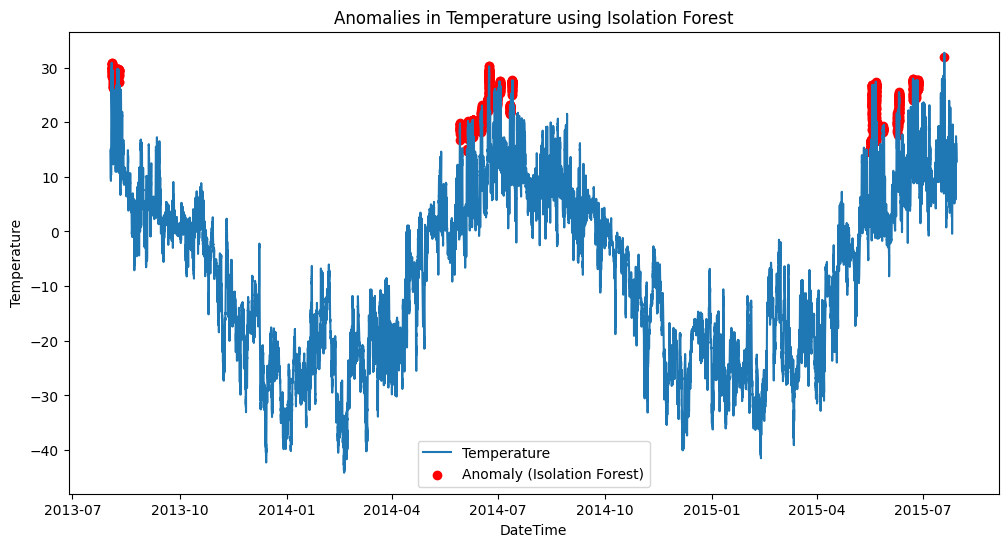

In [7]:
# Plot anomalies detected using Isolation Forest
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temp'], label='Temperature')
plt.scatter(data.index[data['anomaly_if'] == -1], data['temp'][data['anomaly_if'] == -1], color='red', label='Anomaly (Isolation Forest)')
plt.title('Anomalies in Temperature using Isolation Forest')
plt.xlabel('DateTime')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Autoencoder

In [8]:
# Deep Learning Method: Autoencoder with multiple parameters
# Prepare data for Autoencoder
scaled_data = scaler.fit_transform(data[['temp', 'humidity', 'vwc']])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [9]:
# Build the Autoencoder model
autoencoder = Sequential([
    Dense(32, activation='relu', input_shape=(train_data.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train_data.shape[1], activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

In [10]:
# Train the Autoencoder
history = autoencoder.fit(train_data, train_data, epochs=50, batch_size=32, validation_split=0.1, shuffle=True)

# Use the Autoencoder to predict anomalies
predicted_train = autoencoder.predict(train_data)
predicted_test = autoencoder.predict(test_data)

# Calculate reconstruction error
train_mse = np.mean(np.power(train_data - predicted_train, 2), axis=1)
test_mse = np.mean(np.power(test_data - predicted_test, 2), axis=1)

# Define threshold for anomalies
threshold = np.percentile(train_mse, 95) # can be updated
data['anomaly_ae'] = np.concatenate([train_mse, test_mse]) > threshold

# # Get reconstruction loss on the test set
# reconstructions = autoencoder.predict(X_test)
# reconstruction_error = np.mean((reconstructions - X_test) ** 2, axis=1)

# # Set a threshold for anomaly detection (can be tuned)
# threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)

# # Identify anomalies
# anomalies = reconstruction_error > threshold

Epoch 1/50
2058/2058 [==============================] - 6s 2ms/step - loss: 0.5407 - val_loss: 0.5289
Epoch 2/50
2058/2058 [==============================] - 4s 2ms/step - loss: 0.5164 - val_loss: 0.5288
Epoch 3/50
2058/2058 [==============================] - 4s 2ms/step - loss: 0.5162 - val_loss: 0.5288
Epoch 4/50
2058/2058 [==============================] - 4s 2ms/step - loss: 0.5161 - val_loss: 0.5288
Epoch 5/50
2058/2058 [==============================] - 4s 2ms/step - loss: 0.5161 - val_loss: 0.5288
Epoch 6/50
2058/2058 [==============================] - 4s 2ms/step - loss: 0.5159 - val_loss: 0.5287
Epoch 7/50
2058/2058 [==============================] - 4s 2ms/step - loss: 0.5158 - val_loss: 0.5288
Epoch 8/50
2058/2058 [==============================] - 4s 2ms/step - loss: 0.5158 - val_loss: 0.5287
Epoch 9/50
2058/2058 [==============================] - 4s 2ms/step - loss: 0.5157 - val_loss: 0.5287
Epoch 10/50
2058/2058 [==============================] - 4s 2ms/step - loss: 0.515

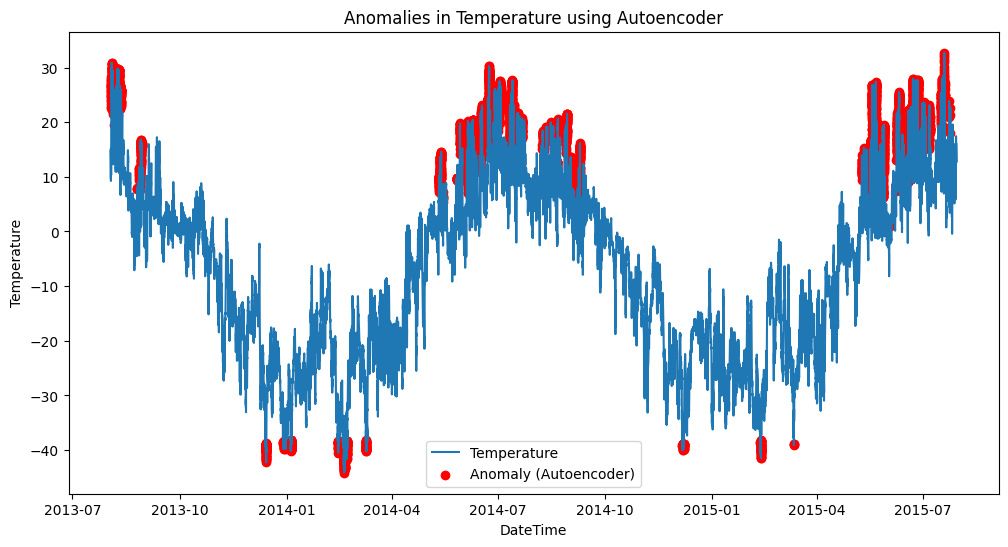

In [11]:
# Plot anomalies detected using Autoencoder
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['temp'], label='Temperature')
plt.scatter(data.index[data['anomaly_ae']], data['temp'][data['anomaly_ae']], color='red', label='Anomaly (Autoencoder)')
plt.title('Anomalies in Temperature using Autoencoder')
plt.xlabel('DateTime')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Epoch 1/10
66891/66891 [==============================] - 102s 2ms/step - loss: 0.0178 - val_loss: 0.0123
Epoch 2/10
66891/66891 [==============================] - 100s 1ms/step - loss: 0.0122 - val_loss: 0.0123
Epoch 3/10
66891/66891 [==============================] - 101s 2ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 4/10
66891/66891 [==============================] - 99s 1ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 5/10
66891/66891 [==============================] - 104s 2ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 6/10
66891/66891 [==============================] - 100s 1ms/step - loss: 0.0122 - val_loss: 0.0123
Epoch 7/10
66891/66891 [==============================] - 136s 2ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 8/10
66891/66891 [==============================] - 115s 2ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 9/10
66891/66891 [==============================] - 100s 1ms/step - loss: 0.0122 - val_loss: 0.0123
Epoch 10/10
654/654 [==========================

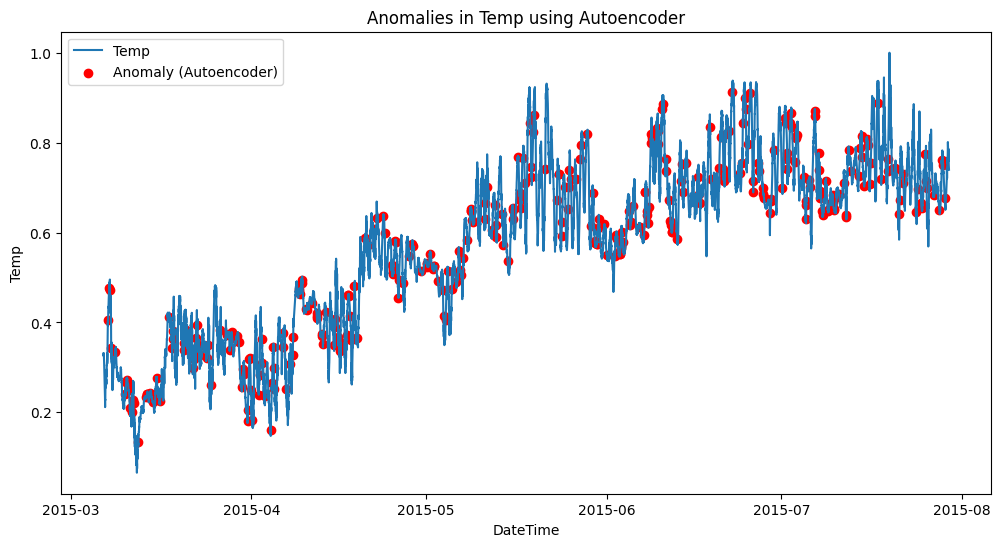

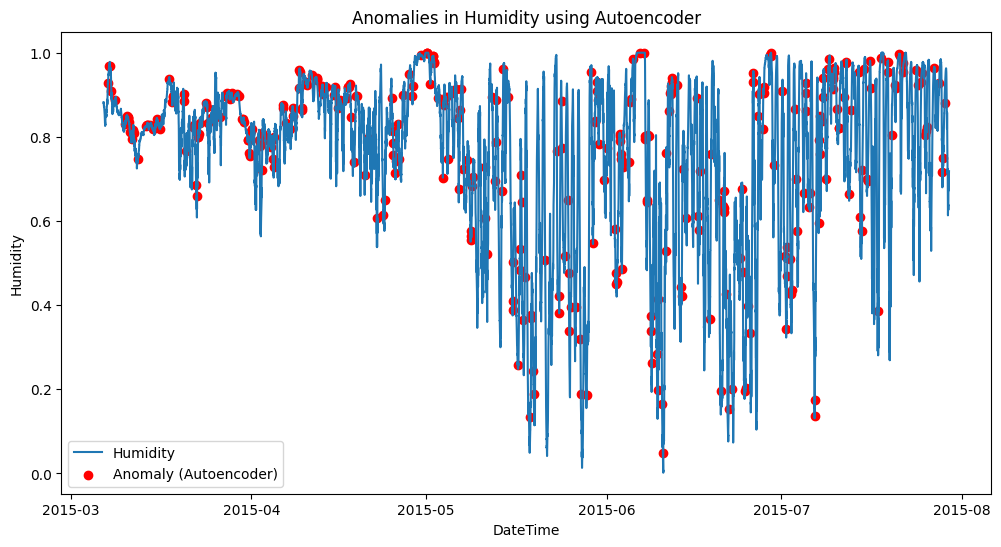

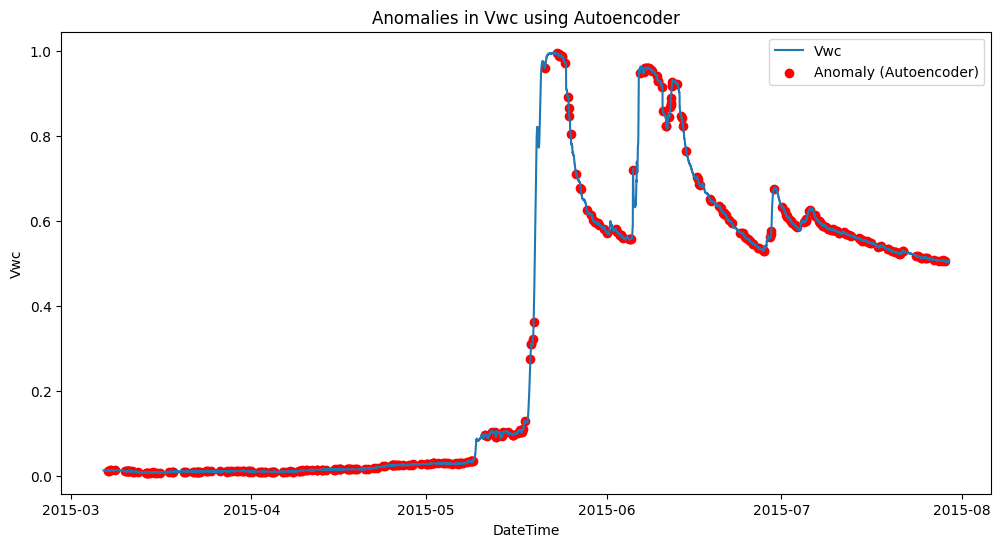

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['temp', 'humidity', 'vwc']])

# Split data into training and testing sets
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=42)

# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 2  # Can be tuned

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=1, shuffle=True, validation_split=0.2)

# Get reconstruction loss on the test set
reconstructions = autoencoder.predict(X_test)
reconstruction_error = np.mean((reconstructions - X_test) ** 2, axis=1)

# Set a threshold for anomaly detection (can be tuned)
threshold = np.mean(reconstruction_error) + 4 * np.std(reconstruction_error)

# Identify anomalies
anomalies = reconstruction_error > threshold
anomaly_indices = np.where(anomalies)[0]

# Create a DataFrame for test data to facilitate plotting
test_data_df = pd.DataFrame(data_scaled[-len(X_test):], columns=data.columns, index=data.index[-len(X_test):])
test_data_df['anomaly'] = 0
test_data_df.iloc[anomaly_indices, -1] = 1

# Plot anomalies detected using Autoencoder for all variables
variables = ['temp', 'humidity', 'vwc']
for var in variables:
    plt.figure(figsize=(12, 6))
    plt.plot(test_data_df.index, test_data_df[var], label=var.capitalize())
    plt.scatter(test_data_df.index[test_data_df['anomaly'] == 1], test_data_df[var][test_data_df['anomaly'] == 1], color='red', label='Anomaly (Autoencoder)')
    plt.title(f'Anomalies in {var.capitalize()} using Autoencoder')
    plt.xlabel('DateTime')
    plt.ylabel(var.capitalize())
    plt.legend()
    plt.show()



In [13]:
# Save the autoencoder model
autoencoder.save('models/anamoly/autoencoder_model.h5')

/Users/roshanwithanage/opt/anaconda3/envs/KTP/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
from tensorflow.keras.models import load_model

# Load the autoencoder model
autoencoder = load_model('models/anamoly/autoencoder_model.h5')